# Table of content
1. **Introduction**
3. **Data importing**
    
    3.1 *Import CIA data*
    
    3.2 *Import annotation data*

    3.3 *Import normal lungs data*
4. **Data cleaning**

    4.1 *Setting the data types right*

    4.2 *Cleaning columns where applied*

    4.3 *Remapping columns*

    4.4 *Normalizing the data*
5. **Data visualization**

    5.1 *Samples of lung images*

    5.2 *Distributions*

6. **Model building, training and testing**

    6.1 *Model building*

    6.2 *Model training*

    6.3 *Model testing*

7. **Results**

    7.1 *Results binary Neural Network*

    7.2 *Results categorical Neural Network*

    7.3 *Results regression Neural Network*
8. **Conclusion**

# Introduction 
This project is about creating an algorithm that would predict the detection of lung cancer based on CT scans. The algorithm would also predict what type of cancer is within the patient and the size of the tumor if applied.

In [1]:
# Import the necessary modules
# If you get a ModuleNotFoundError, use %pip install {module} to install the module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydicom as dicom
from pathlib import Path
import time
from zipfile import ZipFile 
import cv2
from tqdm import tqdm
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, recall_score, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import xmltodict
import functions_project
from sklearn.preprocessing import LabelBinarizer

Functions import succesfull


# Data importing 
In this chapter, the data will be imported. The data consists of two different sets:
- A subselection from the Cancer Imaging Archive (CIA): https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70224216#7022421621c64ff049c44f03bb442ec5eb88bdf2 
- A subselection from Kaggle: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images

A subselection was selected from CIA to avoid having a too big dataset to be processed. The subselection was done from Kaggle because we only needed the data from that subselection.

## Import CIA data

In [2]:
# Set start time
start_time = time.time()

# Get the data that's locally stored
basePath = Path("tciaDownload\manifest-1608669183333\Lung-PET-CT-Dx")

# Get the DICOM files present in the path set before
pathFiles = list(basePath.rglob('*.dcm'))

# Set the DICOM files in a numpy array
images = [dicom.filereader.dcmread(x) for x in pathFiles]
pixels = [image.pixel_array for image in images]
age = [image.PatientAge for image in images]
sex = [image.PatientSex for image in images]
patient_id = [image.PatientID for image in images]
cancer_type = [image.PatientID[8] for image in images]
sop_instance_uid = [image.SOPInstanceUID for image in images]

# Print time execution
print(f"Execution time: {(time.time() - start_time):.3f} seconds")

Execution time: 101.075 seconds


In [3]:
# Put created lists into a dataframe
# Set the has_cancer column manually to 1, since this contains data with patients that have the disease
colNames = ["patient_id", "sop_instance_id", "image_pixels", "patient_age", "patient_sex", "cancer_type", 'has_cancer']
data = [patient_id, sop_instance_uid, pixels, age, sex, cancer_type, 1]

df_sick_lungs = pd.DataFrame()

for colName, values in tqdm(zip(colNames, data)):
    df_sick_lungs[colName] = values

# Display the first few rows and column information
display(df_sick_lungs.head())
print(df_sick_lungs.info())

7it [00:00, 78.84it/s]


,patient_id,sop_instance_id,image_pixels,patient_age,patient_sex,cancer_type,has_cancer
0,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.295499053390...,"[[44, 0, 10, 37, 0, 36, 70, 22, 0, 35, 0, 49, ...",053Y,F,A,1
1,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.314562946465...,"[[50, 0, 22, 26, 42, 25, 6, 51, 35, 7, 13, 33,...",053Y,F,A,1
2,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.142392682681...,"[[16, 3, 0, 89, 20, 10, 1, 22, 12, 61, 10, 25,...",053Y,F,A,1
3,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.117012811165...,"[[58, 0, 25, 71, 40, 48, 0, 0, 32, 49, 4, 46, ...",053Y,F,A,1
4,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.208988389922...,"[[13, 0, 27, 53, 18, 41, 26, 0, 37, 30, 68, 0,...",053Y,F,A,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       7700 non-null   object
 1   sop_instance_id  7700 non-null   object
 2   image_pixels     7700 non-null   object
 3   patient_age      7700 non-null   object
 4   patient_sex      7700 non-null   object
 5   cancer_type      7700 non-null   object
 6   has_cancer       7700 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 421.2+ KB
None


## Import the annotation data

In [4]:
# Loop through zip file to get XML content
path_zip_annotations = "Lung-PET-CT-Dx-Annotations-XML-Files-rev12222020.zip"

cols = ["patient_id", "sop_instance_id", "xmin", "ymin", "xmax", "ymax"]

# Use the createAnnotationDf to add the annotation data
annot_df = functions_project.createAnnotationDf(path_zip_annotations, cols)

In [5]:
# Check the data for the annotation
print(annot_df.info())
display(annot_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31463 entries, 0 to 31462
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       31463 non-null  object
 1   sop_instance_id  31463 non-null  object
 2   xmin             31463 non-null  object
 3   ymin             31463 non-null  object
 4   xmax             31463 non-null  object
 5   ymax             31463 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB
None


,patient_id,sop_instance_id,xmin,ymin,xmax,ymax
0,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407...,286,310,355,286
1,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.103293611003...,304,304,337,304
2,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.136943255924...,278,308,360,278
3,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.155870813347...,290,305,338,290
4,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.184131899543...,301,329,351,301


In [6]:
# Combine the annotation with the sick lungs dataset
df_sick_lungs_annot = df_sick_lungs.merge(annot_df, on = ['patient_id', 'sop_instance_id'])

df_sick_lungs_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607 entries, 0 to 1606
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       1607 non-null   object
 1   sop_instance_id  1607 non-null   object
 2   image_pixels     1607 non-null   object
 3   patient_age      1607 non-null   object
 4   patient_sex      1607 non-null   object
 5   cancer_type      1607 non-null   object
 6   has_cancer       1607 non-null   int64 
 7   xmin             1607 non-null   object
 8   ymin             1607 non-null   object
 9   xmax             1607 non-null   object
 10  ymax             1607 non-null   object
dtypes: int64(1), object(10)
memory usage: 138.2+ KB


In [7]:
# Get the difference in pixels for both x and y axis
x_diff = [abs(int(x_top) - int(x_bottom)) for x_top, x_bottom in zip(df_sick_lungs_annot["xmin"], df_sick_lungs_annot["xmax"])]
y_diff = [abs(int(y_top) - int(y_bottom)) for y_top, y_bottom in zip(df_sick_lungs_annot["ymin"], df_sick_lungs_annot["ymax"])]

# Multiply the x_diff and y_diff lists
diff_squared = [(x * y) for x, y in zip(x_diff, y_diff)]

# Add the results to the df_sick_lungs_annot dataframe
df_sick_lungs_annot['diff_squared'] = diff_squared

df_sick_lungs_annot.head()

,patient_id,sop_instance_id,image_pixels,patient_age,patient_sex,cancer_type,has_cancer,xmin,ymin,xmax,ymax,diff_squared
0,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.173449310598...,"[[0, 25, 51, 3, 0, 49, 22, 0, 63, 26, 0, 49, 5...",053Y,F,A,1,171,256,228,171,4845
1,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.283973423081...,"[[15, 0, 58, 4, 23, 57, 9, 69, 0, 0, 39, 77, 3...",053Y,F,A,1,164,259,227,164,5985
2,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.251378513351...,"[[17, 12, 36, 0, 0, 79, 34, 22, 0, 69, 21, 0, ...",053Y,F,A,1,167,263,231,167,6144
3,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.494618634856...,"[[48, 0, 0, 53, 37, 35, 62, 46, 0, 0, 52, 38, ...",053Y,F,A,1,122,244,233,122,13542
4,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.124409970701...,"[[40, 23, 27, 0, 38, 48, 46, 59, 0, 17, 51, 30...",053Y,F,A,1,111,251,225,111,15960


## Import the normal lungs dataset

In [8]:
# Extract the normal lungs images from the zip file
normalLungs = "normal_ct_scans.zip"
  

normal_lungs_images = functions_project.getNormalLungsData(normalLungs)

100%|██████████| 203/203 [00:02<00:00, 92.93it/s] 


In [9]:
# Create dataframe based on PNG images and add has_cancer column with value of 0
df_normal_lungs = pd.DataFrame()
df_normal_lungs['image_pixels'] = normal_lungs_images
df_normal_lungs["has_cancer"] = 0


# Add rows from other dataframe using the append function: pixel arrays and has_cancer 
sample_df_cancer = df_sick_lungs.sample(n = df_normal_lungs.shape[0])
df_lungs_binary = pd.concat([df_normal_lungs, sample_df_cancer[['image_pixels', 'has_cancer']]], ignore_index= True)

# Display the first few rows and column information
display(df_lungs_binary.head())
print(df_lungs_binary.info())

,image_pixels,has_cancer
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_pixels  406 non-null    object
 1   has_cancer    406 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.5+ KB
None


In [10]:
print(f"Shape of the DICOM dataset image: {df_sick_lungs.image_pixels[0].shape}")
print(f"Shape of the PNG image: {df_normal_lungs.image_pixels[0].shape}")

Shape of the DICOM dataset image: (512, 512)
Shape of the PNG image: (512, 512)


<a id="data_cleaning"></a>
# Data cleaning

In this chapter, the data cleaning will be done. This involves mostly around feature engineering the structure of the images to make it ready for training the data. To do this, we'll do the following:
- Setting the data types of the columns right
- Cleaning columns where applied
- Remapping columns
- Normalizing the data

## Setting the data types of the columns right

In [11]:
print(df_sick_lungs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       7700 non-null   object
 1   sop_instance_id  7700 non-null   object
 2   image_pixels     7700 non-null   object
 3   patient_age      7700 non-null   object
 4   patient_sex      7700 non-null   object
 5   cancer_type      7700 non-null   object
 6   has_cancer       7700 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 421.2+ KB
None


Based on the info method, the following columns needs to be changed:
- `patient_age`: to int
- `cancer_type`: to category
- `has_cancer`: to boolean

### Clean columns

In [12]:
print(f"Lowest age: {min(df_sick_lungs.patient_age)}")
print(f"Highest age: {max(df_sick_lungs.patient_age)}")

Lowest age: 000Y
Highest age: 085Y


As you can see, the age column starts with a '0' and ends with a 'Y'. To clean this data, the 'Y' will be removed and the column data type will be converted to an integer.

In [13]:
df_sick_lungs.head()

,patient_id,sop_instance_id,image_pixels,patient_age,patient_sex,cancer_type,has_cancer
0,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.295499053390...,"[[44, 0, 10, 37, 0, 36, 70, 22, 0, 35, 0, 49, ...",053Y,F,A,1
1,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.314562946465...,"[[50, 0, 22, 26, 42, 25, 6, 51, 35, 7, 13, 33,...",053Y,F,A,1
2,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.142392682681...,"[[16, 3, 0, 89, 20, 10, 1, 22, 12, 61, 10, 25,...",053Y,F,A,1
3,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.117012811165...,"[[58, 0, 25, 71, 40, 48, 0, 0, 32, 49, 4, 46, ...",053Y,F,A,1
4,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.208988389922...,"[[13, 0, 27, 53, 18, 41, 26, 0, 37, 30, 68, 0,...",053Y,F,A,1


In [14]:
# Clean up the patientAge column
df_sick_lungs['patient_age'] = [int(x[0:-1]) for x in df_sick_lungs.patient_age]

In [15]:
# Remap PatientSex and CancerType
cols = ['patient_sex', 'cancer_type']

dict_sex = {"M": "Male", "F": "Female"}
dict_cancer_type = {'A': "Adenocarcinoma", 'B': "Small Cell Carcinoma", 'E': "Large Cell Carcinoma", "G": "Squamous Cell Carcinoma"}

df_sick_lungs = df_sick_lungs.replace({cols[0]: dict_sex, cols[1]: dict_cancer_type})

# Turn PatientSex and CancerType into categorical columns
df_sick_lungs[cols] = df_sick_lungs[cols].astype('category')

df_sick_lungs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   patient_id       7700 non-null   object  
 1   sop_instance_id  7700 non-null   object  
 2   image_pixels     7700 non-null   object  
 3   patient_age      7700 non-null   int64   
 4   patient_sex      7700 non-null   category
 5   cancer_type      7700 non-null   category
 6   has_cancer       7700 non-null   int64   
dtypes: category(2), int64(2), object(3)
memory usage: 316.3+ KB


In [16]:
df_sick_lungs_annot.describe()

,has_cancer,diff_squared
count,1607.0,1607.000000
mean,1.0,5882.301805
std,0.0,4739.260842
min,1.0,0.000000
25%,1.0,2380.000000
50%,1.0,4840.000000
75%,1.0,7806.000000
max,1.0,29760.000000


### Findings
Based on the describe method, the tumor size has a minimum of 0. We want to remove those values, since it could alter the performance of the Neural Network we're trying to built.

In [17]:
# Remove values from the df_sick_lungs_annot data that are 0
df_sick_lungs_annot = df_sick_lungs_annot[df_sick_lungs_annot.diff_squared > 0]

df_sick_lungs_annot.describe()

,has_cancer,diff_squared
count,1603.0,1603.000000
mean,1.0,5896.980037
std,0.0,4736.038792
min,1.0,23.000000
25%,1.0,2391.000000
50%,1.0,4845.000000
75%,1.0,7820.000000
max,1.0,29760.000000


### Normalizing the data
In this paragraph, the data will be normalized. For the binary classificatino model, this will go for the image pixels

In [18]:
# Normalize the data for the binary classification dataframe
#df_lungs_binary['image_pixels'] = df_lungs_binary.image_pixels / 255
#df_sick_lungs['image_pixels'] = df_sick_lungs.image_pixels / 255
df_sick_lungs_annot['image_pixels'] = df_sick_lungs_annot.image_pixels / 255

# Instantiate a scalar and apply it to the diff_squared column
scaler = StandardScaler()
df_sick_lungs_annot['diff_squared_nor'] = scaler.fit_transform(df_sick_lungs_annot[["diff_squared"]]).flatten()


display(df_lungs_binary.head())
display(df_sick_lungs_annot.head())

,image_pixels,has_cancer
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


,patient_id,sop_instance_id,image_pixels,patient_age,patient_sex,cancer_type,has_cancer,xmin,ymin,xmax,ymax,diff_squared,diff_squared_nor
0,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.173449310598...,"[[0.0, 0.09803921568627451, 0.2, 0.01176470588...",053Y,F,A,1,171,256,228,171,4845,-0.222192
1,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.283973423081...,"[[0.058823529411764705, 0.0, 0.227450980392156...",053Y,F,A,1,164,259,227,164,5985,0.018591
2,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.251378513351...,"[[0.06666666666666667, 0.047058823529411764, 0...",053Y,F,A,1,167,263,231,167,6144,0.052174
3,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.494618634856...,"[[0.18823529411764706, 0.0, 0.0, 0.20784313725...",053Y,F,A,1,122,244,233,122,13542,1.614726
4,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.124409970701...,"[[0.1568627450980392, 0.09019607843137255, 0.1...",053Y,F,A,1,111,251,225,111,15960,2.125439


# Data visualization
In this chapter, some visualizations will be done to get more insight into the data. At first, some images from both datasets will be shown. Then a few distribution plots will be shown based on the metadata of the CIA dataset

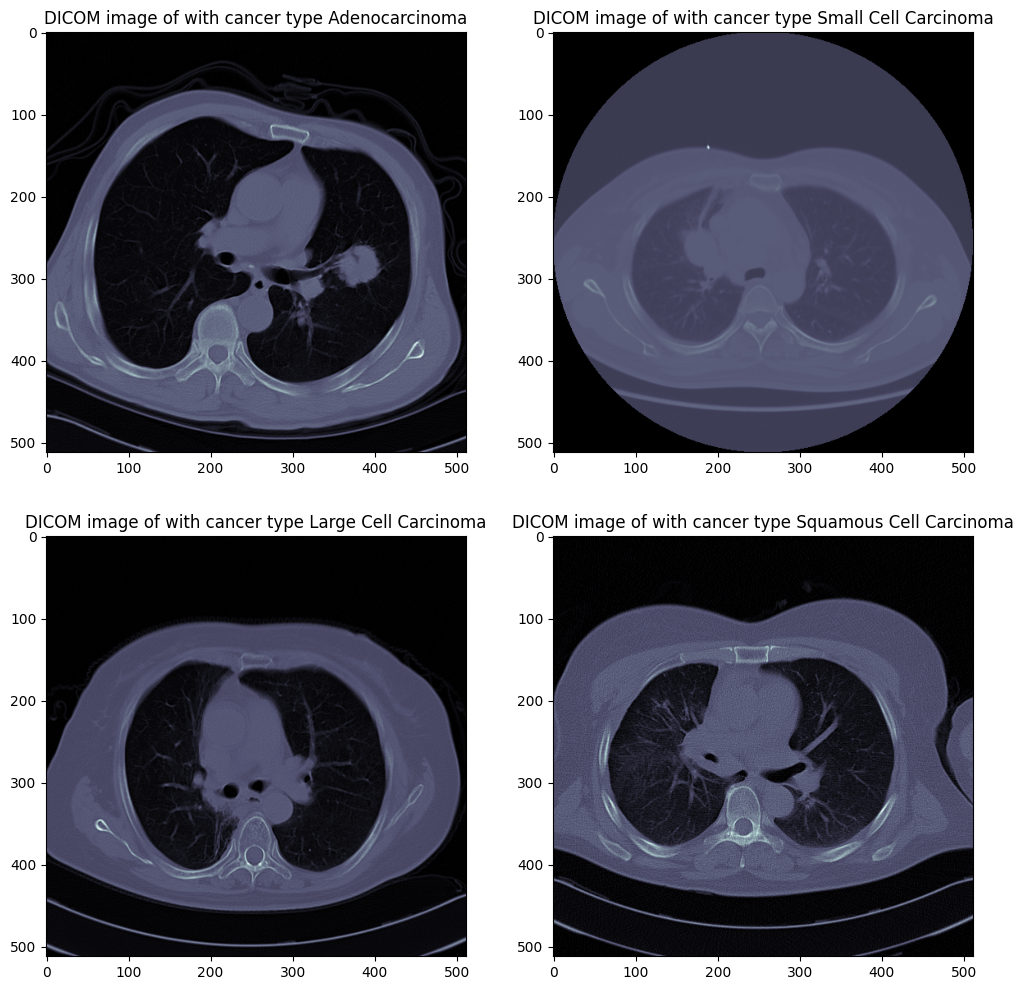

In [19]:
# Show a few images of the lung cancer dataset by type
basepaths_dicom = ["tciaDownload/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0003/07-07-2006-NA-ThoraxAThoraxRoutine Adult-24087/2.000000-ThoraxRoutine  10.0  B70f-09713", 
              "tciaDownload/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-B0013/11-29-2008-NA-e1-81248/2.000000-5mm-24392",
              "tciaDownload/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-G0005/08-12-2004-NA-ThoraxAThoraxRoutine Adult-50679/2.000000-ThoraxRoutine  10.0  B70f-39558",
              "tciaDownload/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-G0015/03-29-2009-NA-ThoraxThoraxabdo Adult-81473/2.000000-ThoraxRoutine  5.0.0  B70f-89589"
]

path_images = ["1-13.dcm", "1-10.dcm", "1-09.dcm", "1-20.dcm"]

titles = ["DICOM image of with cancer type Adenocarcinoma", "DICOM image of with cancer type Small Cell Carcinoma", "DICOM image of with cancer type Large Cell Carcinoma", 
          "DICOM image of with cancer type Squamous Cell Carcinoma"]

# Create subplots
fig, ax = plt.subplots(figsize = (12, 12), ncols = 2, nrows = 2)

# Call displayDicomImage to display the images
for base, path, title, axes in zip(basepaths_dicom, path_images, titles, ax.flat):
    functions_project.displayDicomImage(base, path, title, axes)

plt.show()

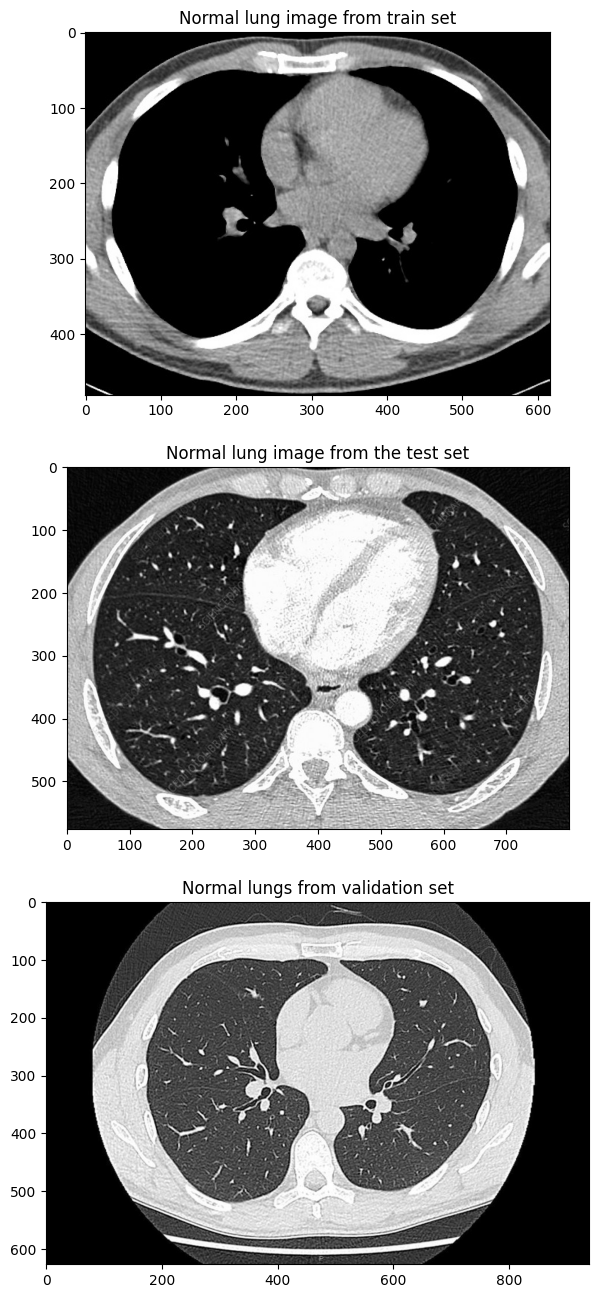

In [20]:
# Show a few imames of the normal lungs
paths = ["normal_train/4.png", "normal_test/8.png", "normal_valid/7.png"]
titles = ["Normal lung image from train set", "Normal lung image from the test set",  "Normal lungs from validation set"]

# Create subplots
fig, ax = plt.subplots(figsize = (16, 16), nrows = 3)

# Call displayDicomImage to display the images
for path, title, axes in zip(paths, titles, ax.flat):
    functions_project.displayPngImage(path, title, axes)

plt.show()

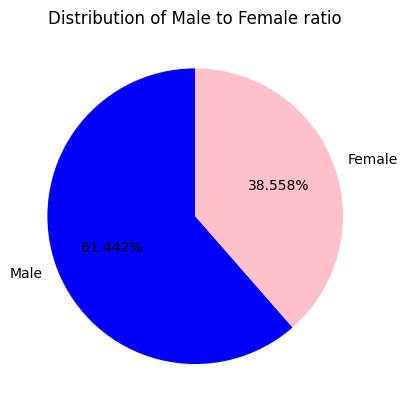

In [21]:
# Check the distirbution of Male to Female patients
# Set up parameters
colors = ['blue', 'pink']
labels = ["Male", "Female"]
title = "Distribution of Male to Female ratio"

functions_project.distributionPlot(df_sick_lungs.patient_sex, colors, labels, title)

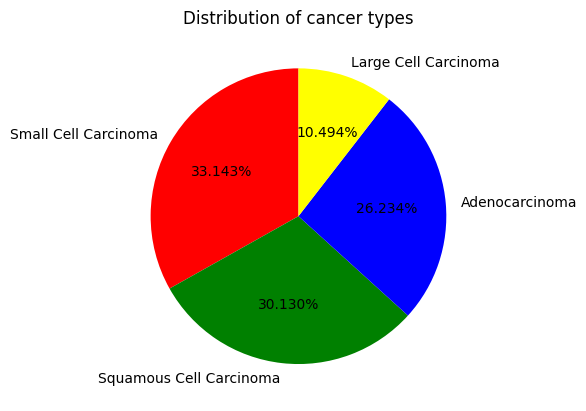

In [22]:
types = ['Adenocarcinoma', 'Small Cell Carcinoma']

# Check the distribution of cancer Types
# Set up parameters
colors = ['Red', 'Green', 'Blue', 'Yellow']
title = "Distribution of cancer types"

# Call distributionPlot function to show distribution
functions_project.distributionPlot(df_sick_lungs.cancer_type, colors, labels, title)

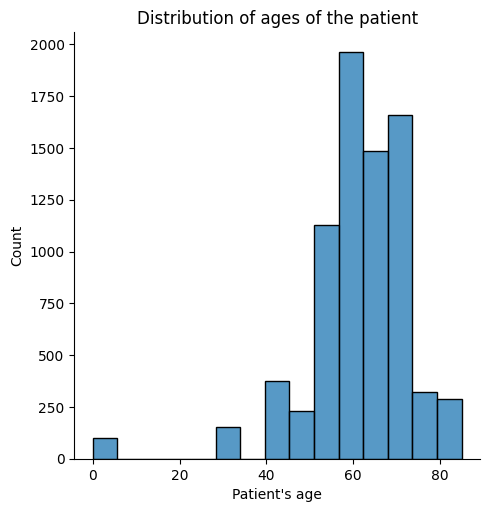

In [23]:
# check the distribution of ages of the patient
sns.displot(df_sick_lungs, x = "patient_age", bins = 15)
plt.title("Distribution of ages of the patient")
plt.xlabel("Patient's age")
plt.show()

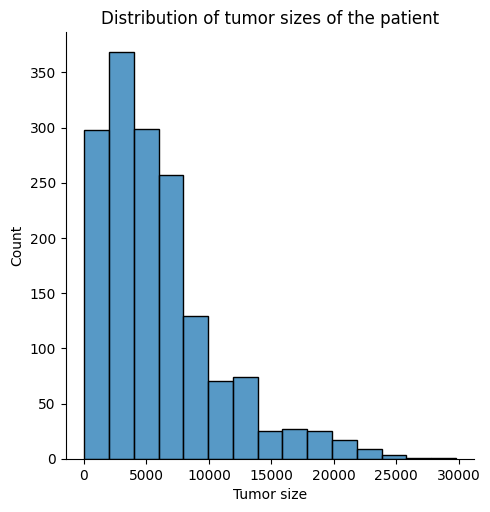

In [24]:
# Check the distribution of the tumore size of the patients
sns.displot(df_sick_lungs_annot, x = "diff_squared", bins = 15)
plt.title("Distribution of tumor sizes of the patient")
plt.xlabel("Tumor size")
plt.show()

In [25]:
df_sick_lungs_annot.diff_squared.describe()

count     1603.000000
mean      5896.980037
std       4736.038792
min         23.000000
25%       2391.000000
50%       4845.000000
75%       7820.000000
max      29760.000000
Name: diff_squared, dtype: float64

## Findings
Based on the graphs, it looks like the data from CIA looks pretty well distributed. Only a few have the age of 0. This might mean that it is not recorded at the time.
What is also noteworthy, is the fact that the color of the Kaggle images are grey and the image of the other dataset is blue.


# Model building, training and testing
In this chapter, the model will be build and trained before it will be tested among the test data.


In [26]:
# Split the data for the binary classification using train_test_split
x_binary = np.array([np.array(val) for val in df_lungs_binary.image_pixels])
y_binary = df_lungs_binary.has_cancer

X_train, X_test, y_train, y_test = train_test_split(x_binary, y_binary, test_size = 0.35, random_state = 42)

# Create the Dataset object to make it ready for the Neural Network
train_ds = Dataset.from_tensor_slices((X_train, y_train))
test_ds = Dataset.from_tensor_slices((X_test, y_test))

In [27]:
df_sick_lungs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   patient_id       7700 non-null   object  
 1   sop_instance_id  7700 non-null   object  
 2   image_pixels     7700 non-null   object  
 3   patient_age      7700 non-null   int64   
 4   patient_sex      7700 non-null   category
 5   cancer_type      7700 non-null   category
 6   has_cancer       7700 non-null   int64   
dtypes: category(2), int64(2), object(3)
memory usage: 316.3+ KB


In [104]:
# Split the data for the categorical classification using train_test_split
x_cat = np.array([np.array(val) for val in df_sick_lungs.image_pixels])
y_cat = pd.get_dummies(df_sick_lungs.cancer_type, prefix_sep='_')

# Split the data into a train and test set
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(x_cat, y_cat, test_size = 0.2, random_state = 42)

# Create the Dataset object to make it ready for the Neural Network
train_ds_cat = Dataset.from_tensor_slices((X_train_cat, y_train_cat))
test_ds_cat = Dataset.from_tensor_slices((X_test_cat, y_test_cat))

In [29]:
# Split the data for the regression using train_test_split
x_reg = np.array([np.array(val) for val in df_sick_lungs_annot.image_pixels])
y_reg = df_sick_lungs_annot.diff_squared_nor

# Split the data into a train and test set
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size = 0.2, random_state = 42)

# Create the Dataset object to make it ready for the Neural Network
train_ds_reg = Dataset.from_tensor_slices((X_train_reg, y_train_reg))
test_ds_reg = Dataset.from_tensor_slices((X_test_reg, y_test_reg))

## Model building

In [72]:
# Set input parameters for binary classification
model_name_binary = "CNN_model_binary"
input_shape_binary = (512, 512)
filters_binary = [512, 256]
metrics_binary = ['accuracy', tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")]
loss_binary = 'binary_crossentropy'
optimizer_binary = 'adam'
lr_binary = 0.001

epochs_binary = 30
batch_size_binary = 6
steps_per_epcoh_binary = 4
patience_binary = 5
monitor_bin = 'val_accuracy'

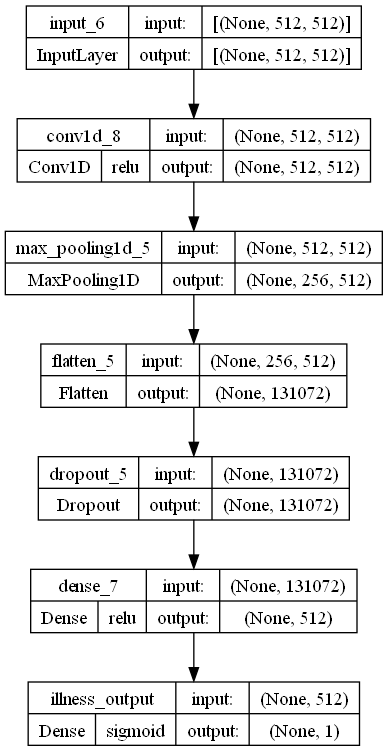

In [73]:
model_binary = functions_project.create_binary_model(model_name_binary, inputShape = input_shape_binary, filters = filters_binary)

# Plot the model using the plot_model function
plot_model(model_binary, model_name_binary + ".png", show_shapes=True, show_layer_activations = True)

In [120]:
# Set input parameters for categorical classification
model_name_categorical = "CNN_model_classification"
input_shape_categorical = (512, 512)
filters_categorical = [512, 256]
metrics_categorical = ['accuracy']
loss_categorical = 'categorical_crossentropy'
monitor_cat = 'val_accuracy'

optimizer_categorical = 'adam'
lr_categorical = 0.01

epochs_categorical = 50
batch_size_categorical = 12
steps_per_epcoh_categorical = 8
patience_categorical = 10

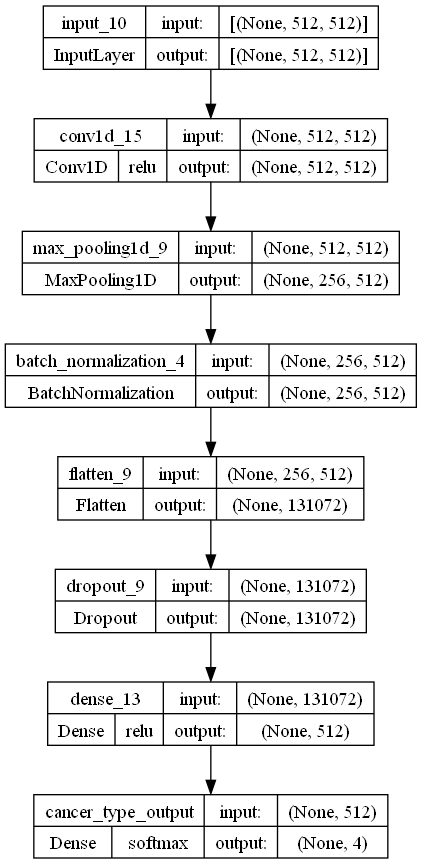

In [121]:
# Instantiate the categorical model
model_categorical = functions_project.create_categorical_model(model_name_categorical, inputShape = input_shape_categorical, filters = filters_categorical)

# Plot the model using the plot_model function
plot_model(model_categorical, model_name_categorical + ".png", show_shapes=True, show_layer_activations = True)

In [118]:
# Set the parameters for the regression model
model_name_regression = "CNN_model_regression"
input_shape_regression= (512, 512)
filters_regression = [512, 256, 128, 64]
metrics_regression = ['mae']
loss_regression = 'mean_absolute_error'
optimizer_regression = 'adam'
lr_regression = 0.001
monitor_regression = 'val_mae'

epochs_regression = 40
batch_size_regression = 10
steps_per_epcoh_regression = 6
patience_regression = 7

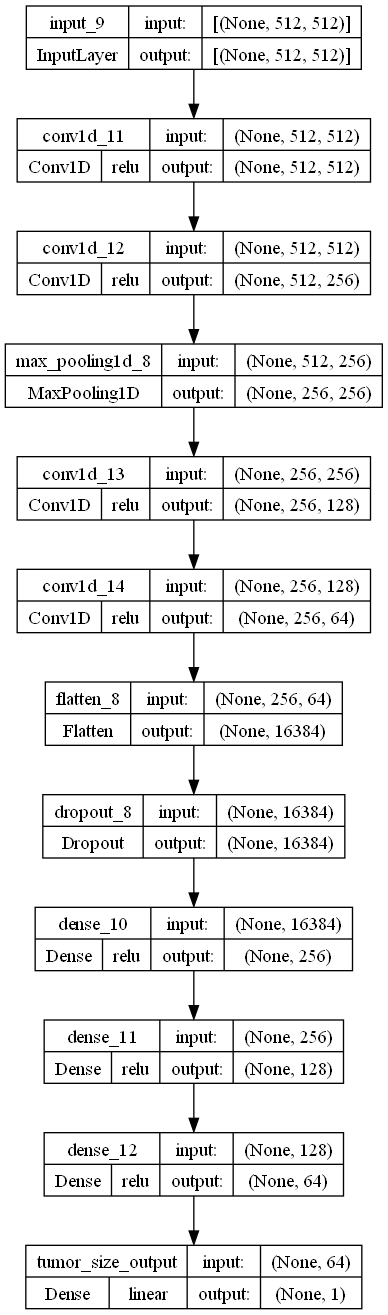

In [119]:
# Instantiate the model based on the Neural Network for regressions
model_regression = functions_project.create_regression_model(model_name_regression, input_shape_regression, filters_regression)

# Show the structure of the model
plot_model(model_regression, model_name_regression + ".png", show_shapes=True, show_layer_activations = True)


## Model training

In [74]:
# Train on the binary model
hist_bin = functions_project.train_model(model_binary, metrics_binary, loss_binary, optimizer_binary, monitor_bin, train_ds, test_ds, 
                   epochs_binary, batch_size_binary, steps_per_epcoh_binary, patience_binary)

Epoch 1/30
4/4 [==============================] - 9s 2s/step - loss: 40437.3633 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000 - val_loss: 2128.2471 - val_accuracy: 0.4615 - val_precision: 0.4615 - val_recall: 1.0000
Epoch 2/30
4/4 [==============================] - 5s 1s/step - loss: 1980.9528 - accuracy: 0.3750 - precision: 0.3182 - recall: 1.0000 - val_loss: 1417.9663 - val_accuracy: 0.8531 - val_precision: 1.0000 - val_recall: 0.6818
Epoch 3/30
4/4 [==============================] - 5s 1s/step - loss: 2856.2314 - accuracy: 0.8333 - precision: 1.0000 - recall: 0.7143 - val_loss: 100.2623 - val_accuracy: 0.8182 - val_precision: 0.7174 - val_recall: 1.0000
Epoch 4/30
4/4 [==============================] - 5s 1s/step - loss: 428.3189 - accuracy: 0.7500 - precision: 0.7143 - recall: 1.0000 - val_loss: 485.1430 - val_accuracy: 0.7692 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/30
4/4 [==============================] - 5s 1s/step - loss: 136.8586 - accuracy: 0.9167 - pre

In [122]:
# Train on the categorical model
hist_cat = functions_project.train_model(model_categorical, metrics_categorical, loss_categorical, optimizer_categorical, monitor_cat, train_ds_cat, test_ds_cat, 
                   epochs_categorical, batch_size_categorical, steps_per_epcoh_categorical, patience_categorical)

Epoch 1/50
8/8 [==============================] - 34s 4s/step - loss: 18903.2480 - accuracy: 0.2604 - val_loss: 1199.4863 - val_accuracy: 0.4240
Epoch 2/50
8/8 [==============================] - 27s 4s/step - loss: 1431.3839 - accuracy: 0.3021 - val_loss: 661.3510 - val_accuracy: 0.3929
Epoch 3/50
8/8 [==============================] - 30s 4s/step - loss: 637.4241 - accuracy: 0.3854 - val_loss: 422.0633 - val_accuracy: 0.3896
Epoch 4/50
8/8 [==============================] - 30s 4s/step - loss: 287.7932 - accuracy: 0.3646 - val_loss: 141.0105 - val_accuracy: 0.4104
Epoch 5/50
8/8 [==============================] - 31s 4s/step - loss: 101.7821 - accuracy: 0.3750 - val_loss: 85.0887 - val_accuracy: 0.4442
Epoch 6/50
8/8 [==============================] - 33s 5s/step - loss: 128.3740 - accuracy: 0.4167 - val_loss: 48.7748 - val_accuracy: 0.4727
Epoch 7/50
8/8 [==============================] - 32s 4s/step - loss: 43.3387 - accuracy: 0.4896 - val_loss: 52.3306 - val_accuracy: 0.4156
Epoch 

In [38]:
# Train for the regression data
hist_reg = functions_project.train_model(model_regression, metrics_regression, loss_regression, optimizer_regression, monitor_regression, train_ds_reg, test_ds_reg,
                       epochs_regression, batch_size_regression, steps_per_epcoh_regression, patience_regression)

Epoch 1/40
6/6 [==============================] - 17s 2s/step - loss: 6.6970 - mae: 5.5853 - val_loss: 3.4350 - val_mae: 2.3188
Epoch 2/40
6/6 [==============================] - 9s 2s/step - loss: 2.9563 - mae: 1.8370 - val_loss: 4.2232 - val_mae: 3.1006
Epoch 3/40
6/6 [==============================] - 9s 2s/step - loss: 2.5487 - mae: 1.4250 - val_loss: 1.8484 - val_mae: 0.7241
Epoch 4/40
6/6 [==============================] - 8s 1s/step - loss: 1.7739 - mae: 0.6499 - val_loss: 1.8495 - val_mae: 0.7267
Epoch 5/40
6/6 [==============================] - 7s 1s/step - loss: 2.0178 - mae: 0.8965 - val_loss: 1.8402 - val_mae: 0.7214
Epoch 6/40
6/6 [==============================] - 8s 1s/step - loss: 2.0219 - mae: 0.9053 - val_loss: 1.8409 - val_mae: 0.7276
Epoch 7/40
6/6 [==============================] - 8s 1s/step - loss: 1.7480 - mae: 0.6373 - val_loss: 1.8239 - val_mae: 0.7170
Epoch 8/40
6/6 [==============================] - 8s 1s/step - loss: 1.8787 - mae: 0.7747 - val_loss: 1.8251 -

## Model testing

In [85]:
pred_nn = model_binary.predict(test_ds.batch(32))

# # Get predicted outputs
preds = []

for i in range(pred_nn.shape[0]):
    data = pred_nn[i]
    
    if data < 1:
        preds.append(0)
    else:
        preds.append(1)



5/5 [==============================] - 2s 361ms/step


In [123]:
# Precict for the categorical data
pred_nn_cat = np.round(model_categorical.predict(test_ds_cat.batch(32)),0)

# Retrieve the predicted value based on index
categorical_test_labels = pd.DataFrame(y_test_cat.values).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred_nn_cat).idxmax(axis=1)

49/49 [==============================] - 21s 401ms/step


In [41]:
# Predict for the test set for the regression model
pred_nn_reg = model_regression.predict(test_ds_reg.batch(32))

11/11 [==============================] - 5s 386ms/step


# Results
In this chapter, the results will be shown. For this, we'll look into the following:
- The True Negative Rate for detecting the lung cancer
- The Mean Absolute Error (MAE) for the size of the tumor
- Accuracy for the type of cancer and the corresponding confidence score.

## Results binary neural network
In this paragraph, the results of the binary neural network will be shown.

### Accuracy

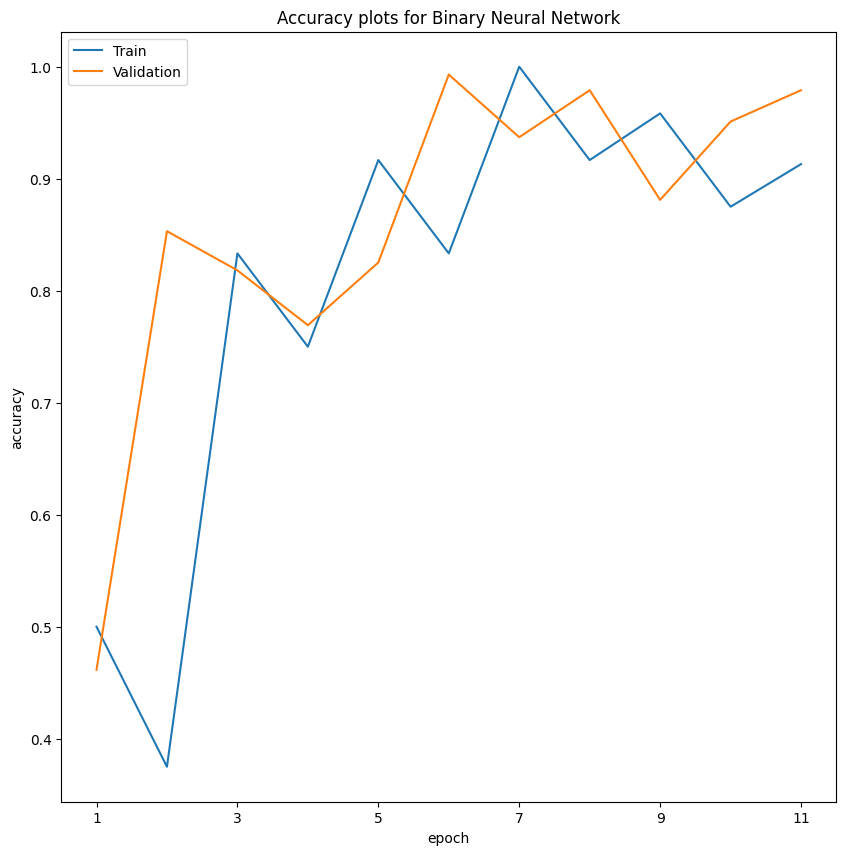

In [87]:
# Set parameters for accuracy plots
y_acc = hist_bin.history['accuracy']
y_val_acc = hist_bin.history['val_accuracy']
title_bin = "Accuracy plots for Binary Neural Network"
ylabel = "accuracy"
figsize_bin = (10, 10)

# summarize history for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_acc, y_val_acc, title_bin, ylabel, figsize_bin)

### Recall score

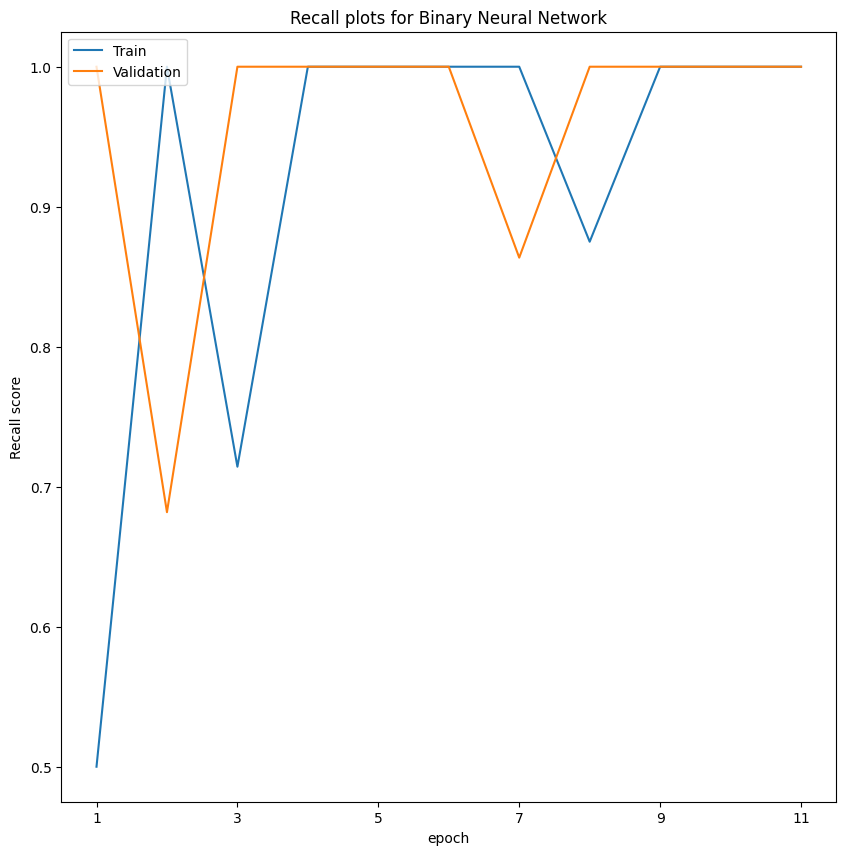

In [88]:
# Display the recall curve
# Set the parameters
y_rec = hist_bin.history['recall']
y_val_rec = hist_bin.history['val_recall']
title_bin_rec = "Recall plots for Binary Neural Network"
ylabel = "Recall score"
figsize_bin = (10, 10)

# summarize history for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_rec, y_val_rec, title_bin_rec, ylabel, figsize_bin)

In [89]:
recall = recall_score(preds, y_test)

print(f"Recall score of binary Neural Network: {recall:.2f}")

Recall score of binary Neural Network: 0.96


### Confusion matrix

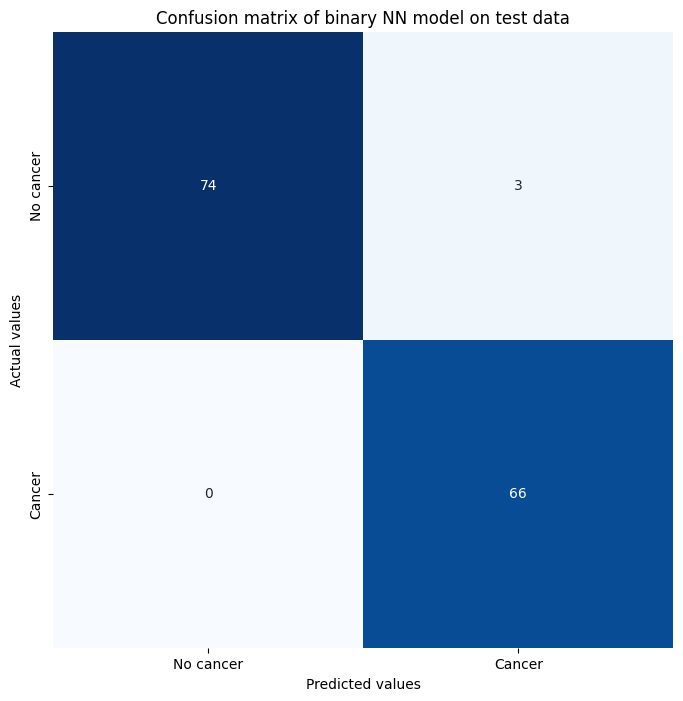

In [90]:
labels_binary_nn = ["No cancer", "Cancer"]
title = "Confusion matrix of binary NN model on test data"
figsize_bin = (8, 8)

# Display the confusion matrix of the binary predictions
functions_project.plot_confusion_matrix(preds, y_test, labels_binary_nn, title, figsize_bin)

### ROC Curve

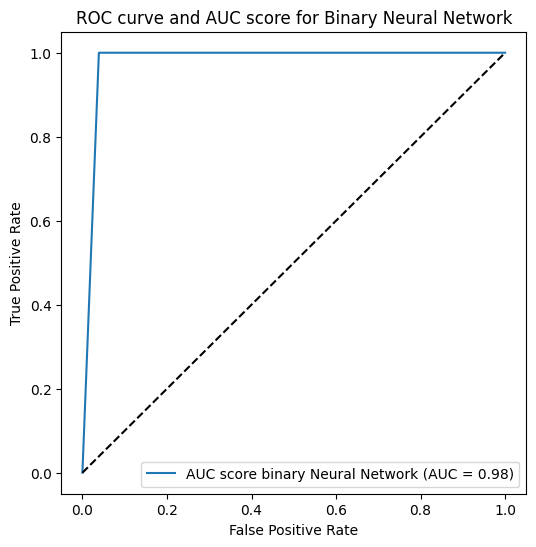

In [91]:
# Call the displayRocCurve function to display the ROC curve and the AUC score
estimator_name_bin = "AUC score binary Neural Network"
figsize_bin = (6, 6)

# Display the ROC curve and print out the AUC
functions_project.displayRocCurve(y_test, preds, estimator_name_bin, figsize_bin)
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.title("ROC curve and AUC score for Binary Neural Network")
plt.show()

### Loss curve

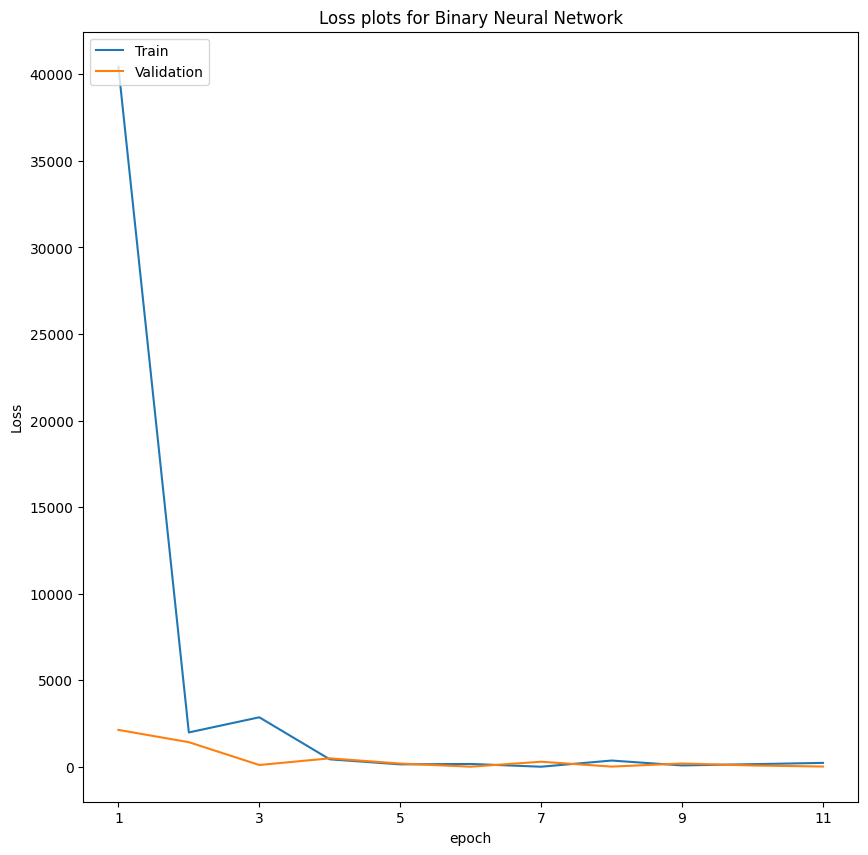

In [92]:
# Set parameters
y_loss = hist_bin.history['loss']
y_val_loss = hist_bin.history['val_loss']
title_bin_loss = "Loss plots for Binary Neural Network"
ylabel = "Loss"
figsize_bin = (10, 10)

# summarize history for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_loss, y_val_loss, title_bin_loss, ylabel, figsize_bin)

### Classification report

In [93]:
# Get the classification report
class_rep_bin = classification_report(y_test, pred_nn, target_names = labels_binary_nn)

print(class_rep_bin)

              precision    recall  f1-score   support

   No cancer       1.00      0.96      0.98        77
      Cancer       0.96      1.00      0.98        66

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



## Results categorical Neural Network
In this paragraph, the results of the Categorical Neural Network will be shown. This is for detecting the type of cancer to the patient.

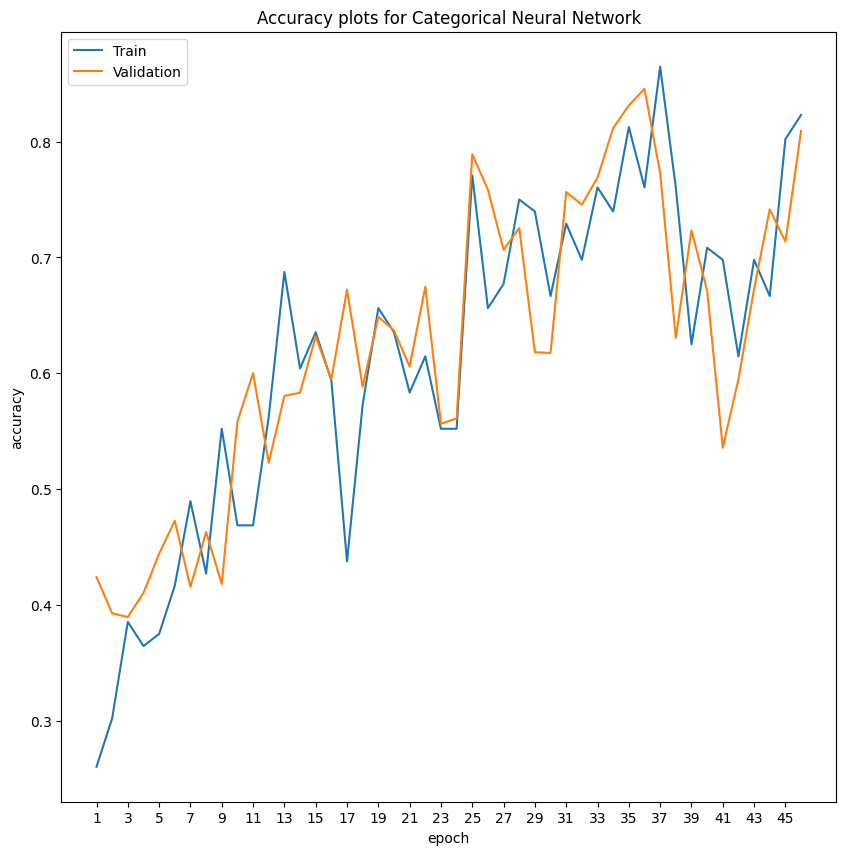

In [124]:
# Set parameters for accuracy plot for the categorical predictions
y_acc_cat = hist_cat.history['accuracy']
y_val_acc_cat = hist_cat.history['val_accuracy']
title_cat = "Accuracy plots for Categorical Neural Network"
ylabel = "accuracy"
figsize_cat = (10, 10)

# Summarize the historday for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_acc_cat, y_val_acc_cat, title_cat, ylabel, figsize_cat)

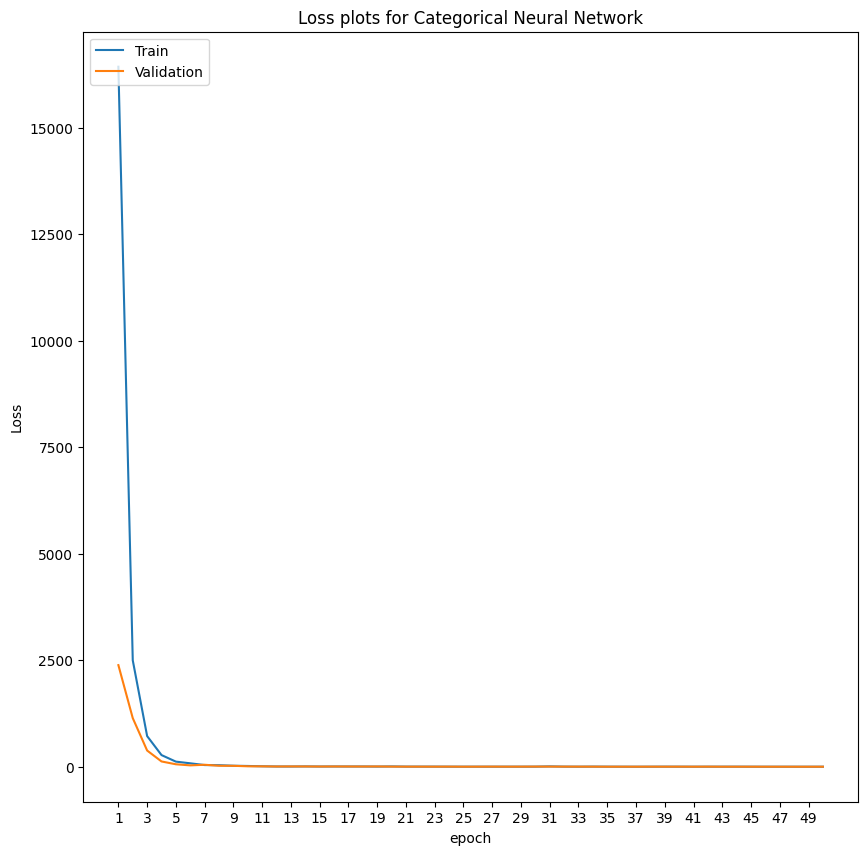

In [96]:
# Set parameters for loss plot for the categorical predictions
y_loss_cat = hist_cat.history['loss']
y_val_loss_cat = hist_cat.history['val_loss']
title_cat_loss = "Loss plots for Categorical Neural Network"
ylabel = "Loss"
figsize_cat = (10, 10)

# Summarize the historday for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_loss_cat, y_val_loss_cat, title_cat_loss, ylabel, figsize_cat)

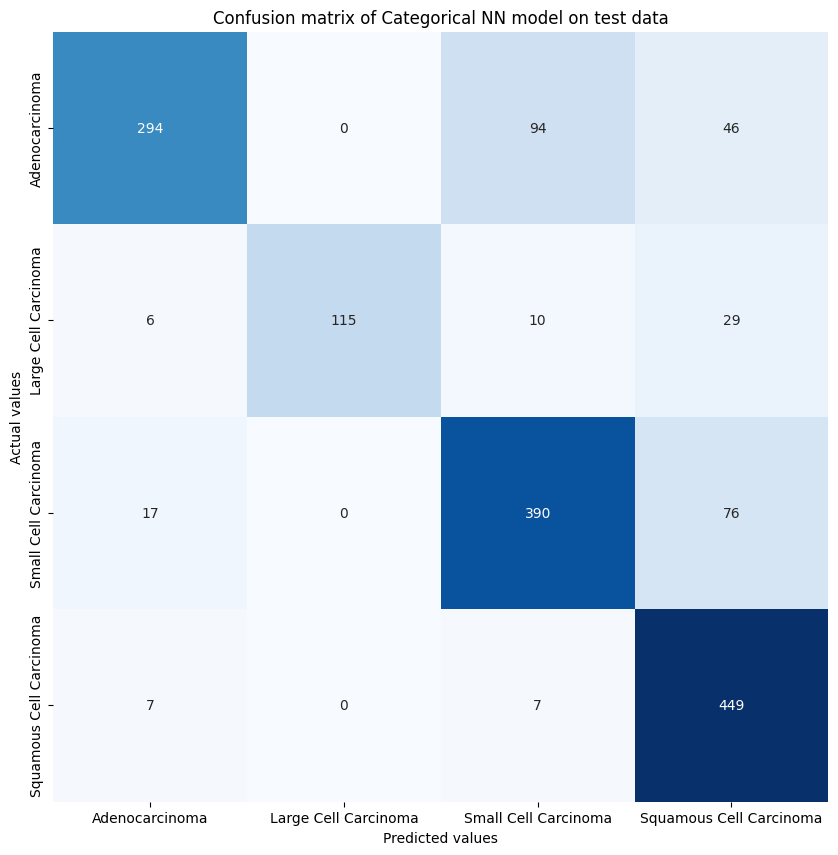

In [125]:
labels_categorical_nn = ["Adenocarcinoma", "Large Cell Carcinoma", "Small Cell Carcinoma", "Squamous Cell Carcinoma"]
title_cat = "Confusion matrix of Categorical NN model on test data"
figsize_cat = (10, 10)

# Display the confusion matrix of the categorical predictions
functions_project.plot_confusion_matrix(categorical_preds, categorical_test_labels, labels_categorical_nn, title_cat, figsize_cat)

In [126]:
acc = accuracy_score(y_test_cat, pred_nn_cat)

print(f"Accuracy score of Categorical Neural Network: {acc:.2f}")

Accuracy score of Categorical Neural Network: 0.81


In [127]:
# Get the classification report
class_rep_cat = classification_report(y_test_cat, pred_nn_cat, target_names = labels_categorical_nn)

print(class_rep_cat)

                         precision    recall  f1-score   support

         Adenocarcinoma       0.92      0.66      0.77       434
   Large Cell Carcinoma       1.00      0.72      0.84       160
   Small Cell Carcinoma       0.78      0.81      0.79       483
Squamous Cell Carcinoma       0.75      0.97      0.84       463

              micro avg       0.81      0.81      0.81      1540
              macro avg       0.86      0.79      0.81      1540
           weighted avg       0.83      0.81      0.81      1540
            samples avg       0.81      0.81      0.81      1540



c:\Users\ardejong\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


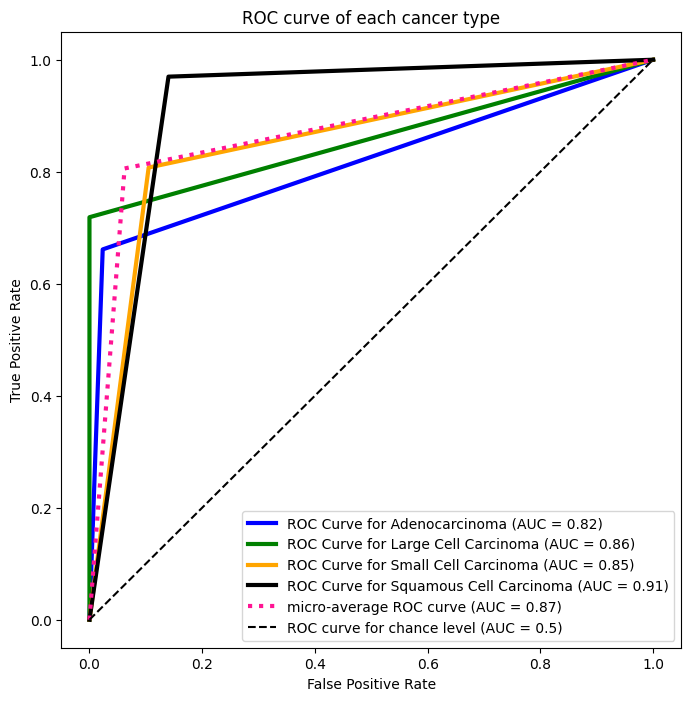

In [128]:
# Use a labelbianrizer to binarize the targets
label_binarizer = LabelBinarizer().fit(y_train_cat)
y_onehot_test = label_binarizer.transform(y_test_cat)
fpr_cat, tpr_cat, _ = roc_curve(y_onehot_test.ravel(), pred_nn_cat.ravel())
auc_micro = roc_auc_score(y_test_cat, pred_nn_cat, multi_class = "ovr", average = "micro")

# Set parameters
colours = ["blue", "green", "orange", "black"]

fig, ax = plt.subplots(figsize=(8, 8))

# Loop through each column for the cancer type data
for i in range(y_test_cat.shape[1]):
    # Set the data
    true = y_test_cat.values[:, i]
    pred = pred_nn_cat[:, i]
    auc = roc_auc_score(true, pred)
    name = f"ROC Curve for {y_test_cat.columns[i]}"

    # Create the ROC curve
    RocCurveDisplay.from_predictions(true, pred, color = colours[i], ax = ax, name = name, linewidth = 3)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve of each cancer type")


# Add the micro-averaged OvR to the independent outcomes
plt.plot(fpr_cat, tpr_cat, label=f"micro-average ROC curve (AUC = {auc_micro:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth = 3)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")

plt.legend()
# Display the outcomes
plt.show()
    

## Results regression Neural Network
In this paragraph, the results for the regression Neural Network will be shown. This will mainly focus on the Mean Absolute Error(MAE)

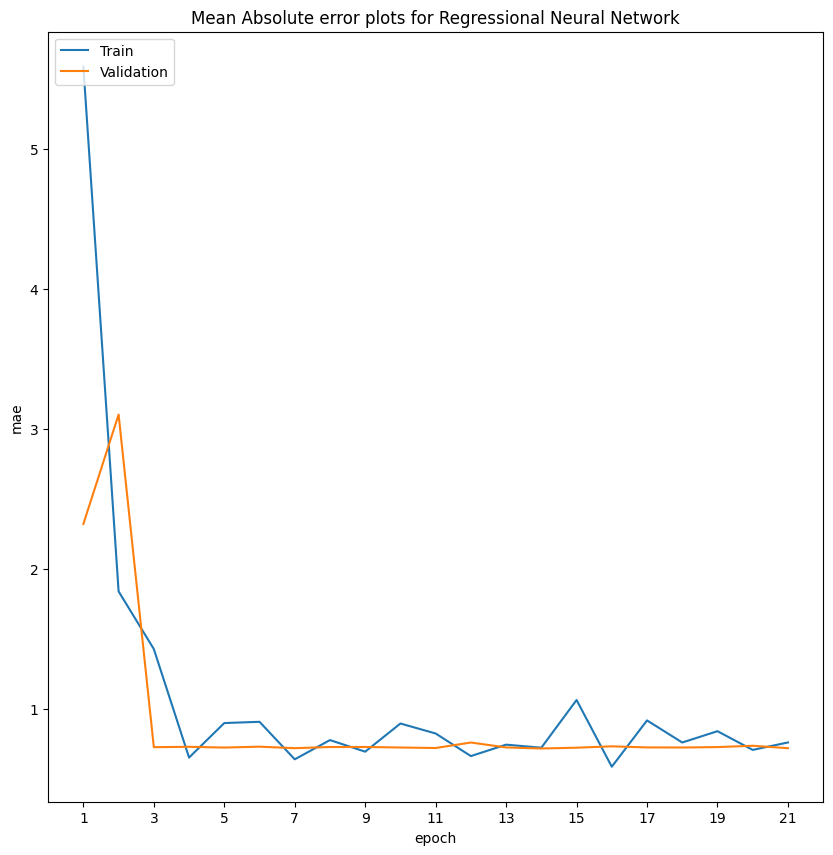

In [130]:
# Set parameters for MAE plot for the regression predictions
y_mae_reg = hist_reg.history['mae']
y_mae_val_reg = hist_reg.history['val_mae']
title_reg = "Mean Absolute error plots for Regressional Neural Network"
ylabel = "mae"
figsize_reg = (10, 10)

# Summarize the historday for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_mae_reg, y_mae_val_reg, title_reg, ylabel, figsize_reg)

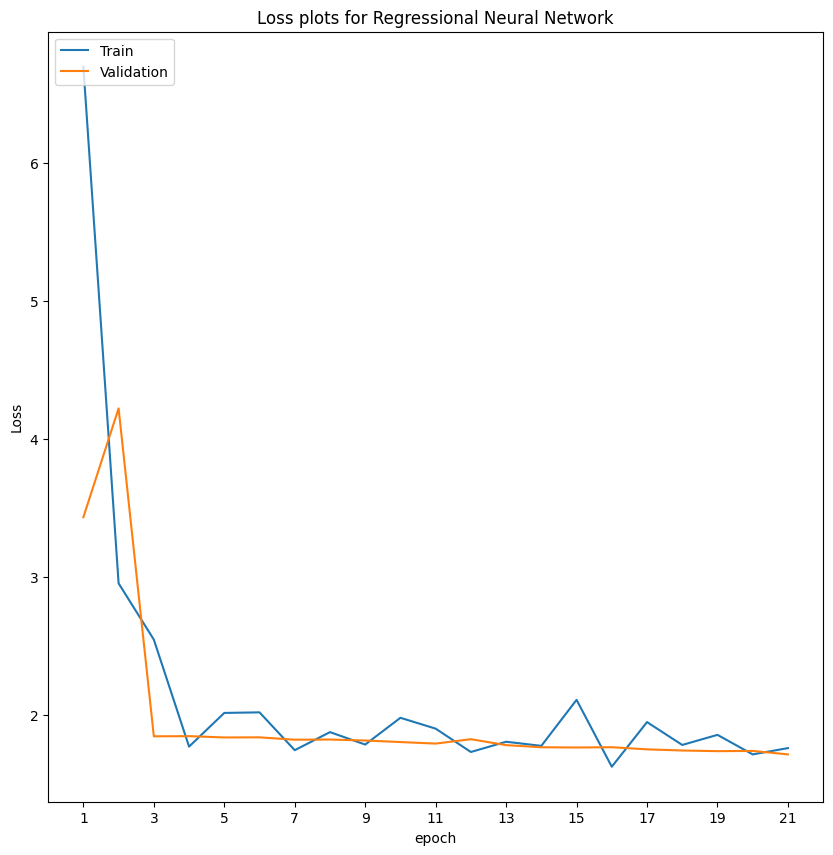

In [129]:
# Set parameters for loss plot for the regression predictions
y_mae_reg_loss = hist_reg.history['loss']
y_mae_val_reg_loss = hist_reg.history['val_loss']
title_reg_loss = "Loss plots for Regressional Neural Network"
ylabel = "Loss"
figsize_reg = (10, 10)

# Summarize the historday for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_mae_reg_loss, y_mae_val_reg_loss, title_reg_loss, ylabel, figsize_reg)

In [61]:
# Call the regression_results funciton to display the results of the Regression Neural Network
functions_project.regression_results(y_test_reg, pred_nn_reg)

Explained_variance score for Regression Neural Network: 0.00
R2 score for Regression Neural Network: -0.0373
Mean absolute error score for Regression Neural Network: 0.7169
Mean Squared error for Regression Neural Network: 1.0212
Root Mean Squared error for Regression Neural Network: 1.0105


# Conclusion
Based on the results of the Neural Networks, we can conclude the following things:
- The recall score (a.k.a. True Negative Rate) for the binary predictions is 1.00. Although that is an amazing score, it could be less when the size of the data involved is larger. Nonetheless, it is expected that the results would still be very good.
- The accuracy score for the binary is 0.61. That is an ok score, but it is not the target we want to meet, which is 0.80. 
- For the regression model, we wanted to look at the Mean Absolute Error. It is quite difficult to estimate what a good MAE would be, but we can see from the graph that the MAE is not improving a lot after it has been run. Therefore, we can conclude that the model is not sufficient yet. 